In [1]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-16 12:15:00.379070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 12:15:00.388440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 12:15:00.398536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [2]:
data = Dataset('15min')
data = data.preprocess()
# data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
print(len(data.columns))
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 1  # Number of 15-min we want to look into the future based on the past (Out).
n_past = 16   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
# data = pd.concat([data, categorical_data], axis = 1) #without categorical
X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train = np.log1p(Y_train)
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
# Y_val = np.log1p(Y_val)
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
# Y_test = np.log1p(Y_test)
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


X_train , Y_train =  split_sequence(X_train, Y_train, n_past, n_future)
X_val , Y_val =  split_sequence(X_val, Y_val, n_past, n_future)
X_test , Y_test =  split_sequence(X_test, Y_test, n_past, n_future)


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Fore

37
198.23530425829813
380.9409999996424
5.430999994277954
Train sizes:
(7408, 16, 36) (7408, 1, 1)
Validation sizes:
(638, 16, 36) (638, 1, 1)
Test sizes:
(639, 16, 36) (639, 1, 1)


# Optuna Objective

In [3]:
# def objective(trial):
#     clear_session()
#     low = trial.suggest_categorical("low", [128, 256, 512])
#     lr_schedule = ExponentialDecay(0.0001, decay_steps=1400, decay_rate=0.96, staircase=True)
#     #how deep the layers should be
#     n_layers = trial.suggest_int("n_layers", 1, 3, step = 1)
#     model = Sequential()
    
#     for i in range(n_layers):
#         lstm_units = low * (2 ** i)
#         activation_func = trial.suggest_categorical(f"activation_func", ['relu', 'tanh', 'leaky_relu'])
#         print(lstm_units)
#         model.add(Bidirectional(LSTM(units = lstm_units, 
#                                      activation= activation_func, 
#                                      return_sequences=True, 
#                                      dropout = trial.suggest_float(f"dropout_rate_lstm_{i}", 0.1, 0.5, step = 0.1),
#                                      recurrent_dropout= trial.suggest_float(f"rec_dropout_rate_lstm_{i}", 0.1, 0.5, step = 0.1),
#                                      input_shape=(X_train.shape[1], X_train.shape[2]))))
#     model.add(TimeDistributed(Dense(units = trial.suggest_categorical("dense_units", [16, 32, 64]), activation= activation_func)))
#     model.add(Dropout(trial.suggest_float("dropout_rate", 0.1, 0.5, step = 0.1)))
#     model.add(TimeDistributed(Dense(1)))
#     model.add(Flatten())
#     model.add(Dense(n_future))
#     model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.0001), metrics=['mse', 'mae', 'mape'])
    
#     history = model.fit(X_train, Y_train, epochs= 15, batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]), validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=8)],
#                         verbose=1, shuffle=True)
    

#     # score
#     score = model.evaluate(X_val,Y_val)

#     return score[0]

# Optuna study run

In [4]:
# study = optuna.create_study(direction= "minimize", storage= "sqlite:///halcor_study.db", study_name="halcor_study")
# study.optimize(objective, n_trials=25, timeout=6000000000)
# print("Number of finished trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [5]:
# import optuna.visualization as vis

# vis.plot_optimization_history(study)
# vis.plot_param_importances(study)
# vis.plot_slice(study)

# Optuna load study

In [6]:
loaded_study = optuna.load_study(study_name='halcor_study', storage="sqlite:///halcor_study.db")

best_trial = loaded_study.best_trial
best_params = best_trial.params
best_params, best_trial.value
# I can continue optimizing if it crashed or something
# loaded_study.optimize(objective, n_trials=50)

({'low': 256,
  'n_layers': 3,
  'activation_func': 'relu',
  'dropout_rate_lstm_0': 0.1,
  'rec_dropout_rate_lstm_0': 0.30000000000000004,
  'dropout_rate_lstm_1': 0.2,
  'rec_dropout_rate_lstm_1': 0.1,
  'dropout_rate_lstm_2': 0.1,
  'rec_dropout_rate_lstm_2': 0.1,
  'dense_units': 32,
  'dropout_rate': 0.1,
  'batch_size': 16},
 0.021812664344906807)

In [7]:
Y_train

array([[[0.7765186 ]],

       [[0.69435035]],

       [[0.82232431]],

       ...,

       [[0.05255785]],

       [[0.03812948]],

       [[0.04584166]]])

# Model (I run here the optimal hyperparams for more epochs)

In [9]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=2500, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.2, input_shape=(X_train.shape[1], X_train.shape[2])), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False, dropout= 0.1, recurrent_dropout= 0.2), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))


    # model = Sequential([
    # Bidirectional(
    #     LSTM(units=50, 
    #          input_shape=(X_train.shape[1], X_train.shape[2]),  # (timesteps, features)
    #          return_sequences=True),   # Return output for each time step
    #     merge_mode='concat'),          # Merge the forward and backward LSTM outputs
    # Dropout(0.2),                      # Dropout with a rate of 20%
    
    # # Add another LSTM layer if needed
    # Bidirectional(
    #     LSTM(units=50, return_sequences=False),   # Second LSTM layer
    #     merge_mode='concat'),          # Merge the forward and backward outputs
    # Dropout(0.2),                      # Dropout with a rate of 20%

    # Dense(units=1)    # Apply Dense layer to each time step's output
    # ])
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae', 'mape'])

    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-15-min(15min).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5,             # Number of epochs with no improvement after which training will stop
    mode='min',             # Stop when the quantity monitored has stopped decreasing
    verbose=1,              # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)
model = create_model()

history = model.fit(X_train, Y_train[:,:,0], validation_data=(X_val, Y_val[:,:,0]), epochs=40, batch_size=16, callbacks=[checkpoint_callback, early_stopping_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/40


I0000 00:00:1731332114.820967  647903 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731332114.852457  647903 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731332114.852613  647903 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731332114.853605  647903 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

 25/463 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1442 - mae: 0.3538 - mape: 856.7539

I0000 00:00:1731332118.961124  657634 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


455/463 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0935 - mae: 0.2725 - mape: 50010.8359
Epoch 1: val_loss improved from inf to 0.07748, saving model to ./models/model-15-min(15min).keras

Epoch 1: Learning rate is 9.999999747378752e-05
463/463 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0934 - mae: 0.2722 - mape: 50428.0039 - val_loss: 0.0775 - val_mae: 0.2475 - val_mape: 180.8468
Epoch 2/40
458/463 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0887 - mae: 0.2651 - mape: 44927.5977
Epoch 2: val_loss improved from 0.07748 to 0.06160, saving model to ./models/model-15-min(15min).keras

Epoch 2: Learning rate is 9.999999747378752e-05
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0886 - mae: 0.2649 - mape: 45172.3438 - val_loss: 0.0616 - val_mae: 0.2199 - val_mape: 145.8481
Epoch 3/40
459/463 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0848 - mae: 0.2538 - mape: 48285.8789
Epoch 3: val_loss improved from 0.06160 to 0.05206, saving model to ./models/model-15-min(15min).keras

Epoch 3: Lear

In [ ]:
# save model
model.save('./models/model-15-min(15min).keras')

In [ ]:
from keras.models import load_model
# load model

model = load_model('./models/model-15-min(15min).keras')

# continue training for a few epochs with a lower lr

In [ ]:
# model.compile(loss='mse', optimizer=Adam(learning_rate=0.00003), metrics=['mse', 'mae', 'mape'])
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

In [10]:
predictions = model.predict(X_test)
# predictions = predictions.reshape(predictions.shape[0], predictions.shape[1] * predictions.shape[2])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [11]:
predictions

array([[0.02119207],
       [0.02042232],
       [0.02273835],
       [0.02427479],
       [0.0226583 ],
       [0.02085024],
       [0.02069154],
       [0.02111933],
       [0.02158784],
       [0.0222741 ],
       [0.0231586 ],
       [0.02137564],
       [0.01921955],
       [0.02005525],
       [0.02285064],
       [0.02369179],
       [0.02099524],
       [0.01895475],
       [0.01994199],
       [0.02185193],
       [0.02177206],
       [0.02146258],
       [0.02117669],
       [0.01994071],
       [0.01914285],
       [0.02094339],
       [0.02333663],
       [0.02283226],
       [0.01903555],
       [0.01777495],
       [0.02005376],
       [0.0217969 ],
       [0.02036306],
       [0.01935928],
       [0.01895187],
       [0.01825165],
       [0.01834928],
       [0.021547  ],
       [0.02475999],
       [0.02379191],
       [0.021586  ],
       [0.0244972 ],
       [0.03060848],
       [0.03241448],
       [0.02944961],
       [0.02995448],
       [0.03197259],
       [0.033

In [12]:
min(predictions), max(predictions)

(array([0.00144906], dtype=float32), array([0.7418092], dtype=float32))

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], features))
for i in range(zeros.shape[0]):
    zeros[i][0] = predictions[i]


predictions = scaler_Y.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((X_test.shape[0],features))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[:, :, 0][i]
original = scaler_Y.inverse_transform(zeros)
original = [i[0] for i in original]
# original = Y_test
# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 67.37116125798472
Mean Squared Error (MSE): 8048.962545838434
Root Mean Squared Error (RMSE): 89.71601053233717
R² Score: 0.4389546525523822
Adjusted R² Score: 0.42452261789135026
Median Absolute Error: 52.82719336596455
Mean Absolute Percentage Error (MAPE): 108.02971308327139 %


/tmp/ipykernel_647903/3503997483.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = predictions[i]
/tmp/ipykernel_647903/3503997483.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[:, :, 0][i]


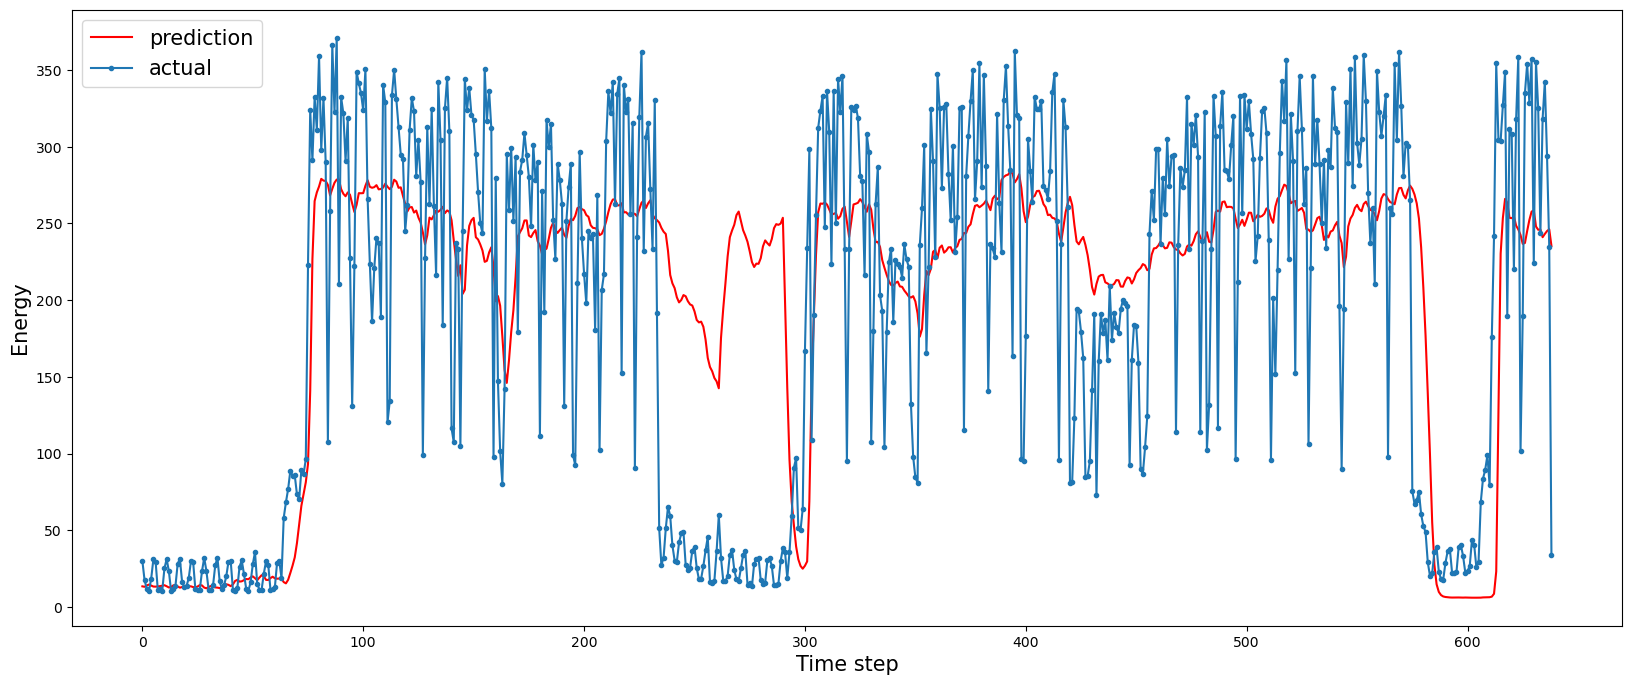

In [14]:
pyplot.figure(figsize=(20,8))
pyplot.plot(predictions, label='prediction', color="r")
pyplot.plot(original, label='actual', marker='.')
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

# Trying XGBoost for the coarser intervals

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [59]:
# data = Dataset('15min')
# data = data.preprocess()
data = pd.read_csv('/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# start_time = pd.Timestamp('2022-05-31 07:00:00')
# end_time = pd.Timestamp('2022-06-01 07:30:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# start_time = pd.Timestamp('2022-05-31 08:00:00')
# end_time = pd.Timestamp('2022-06-01 09:00:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# data.to_csv('/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv')
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [60]:
# Assuming your data is in a pandas DataFrame df with 'target' column to predict
data['lag_1'] = data['Energy'].shift(1)
data['lag_2'] = data['Energy'].shift(2)
data['lag_3'] = data['Energy'].shift(3)
data['lag_4'] = data['Energy'].shift(4)


# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)
features = len(cols) - 1  # Number of features


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
# data = pd.concat([data, categorical_data], axis = 1) #without categorical

X = data.drop(columns='Energy')
column_names = X.columns
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

train_data = xgb.DMatrix(X_train, label=Y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]
evals_result = {}
# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=10000, evals=evals, early_stopping_rounds=50, verbose_eval=100, evals_result = evals_result)
y_pred = model.predict(test_data)


198.23530425829813
380.9409999996424
5.430999994277954
Train sizes:
(7425, 38) (7425, 1)
Validation sizes:
(655, 38) (655, 1)
Test sizes:
(656, 38) (656, 1)
[0]	train-rmse:0.29334	eval-rmse:0.30068


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:56:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.27245	eval-rmse:0.27560
[200]	train-rmse:0.25394	eval-rmse:0.25314
[300]	train-rmse:0.23762	eval-rmse:0.23293
[400]	train-rmse:0.22323	eval-rmse:0.21486
[500]	train-rmse:0.21059	eval-rmse:0.19885
[600]	train-rmse:0.19949	eval-rmse:0.18489
[700]	train-rmse:0.18973	eval-rmse:0.17238
[800]	train-rmse:0.18118	eval-rmse:0.16132
[900]	train-rmse:0.17364	eval-rmse:0.15164
[1000]	train-rmse:0.16708	eval-rmse:0.14289
[1100]	train-rmse:0.16132	eval-rmse:0.13497
[1200]	train-rmse:0.15634	eval-rmse:0.12851
[1300]	train-rmse:0.15193	eval-rmse:0.12268
[1400]	train-rmse:0.14808	eval-rmse:0.11734
[1500]	train-rmse:0.14470	eval-rmse:0.11258
[1600]	train-rmse:0.14177	eval-rmse:0.10848
[1700]	train-rmse:0.13919	eval-rmse:0.10477
[1800]	train-rmse:0.13687	eval-rmse:0.10132
[1900]	train-rmse:0.13483	eval-rmse:0.09855
[2000]	train-rmse:0.13305	eval-rmse:0.09639
[2100]	train-rmse:0.13150	eval-rmse:0.09462
[2200]	train-rmse:0.13013	eval-rmse:0.09312
[2300]	train-rmse:0.12886	eval-rmse:0.091

In [61]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 41))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler_Y.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],41))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler_Y.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean squared error (MSE): {mean_squared_error(original, predictions)}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 23.017948798712702
Mean squared error (MSE): 1055.1731454460837
Root Mean Squared Error (RMSE): 32.48342878216651
R² Score: 0.9284194032215236
Adjusted R² Score: 0.9240108737602885


/tmp/ipykernel_85660/3799769502.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


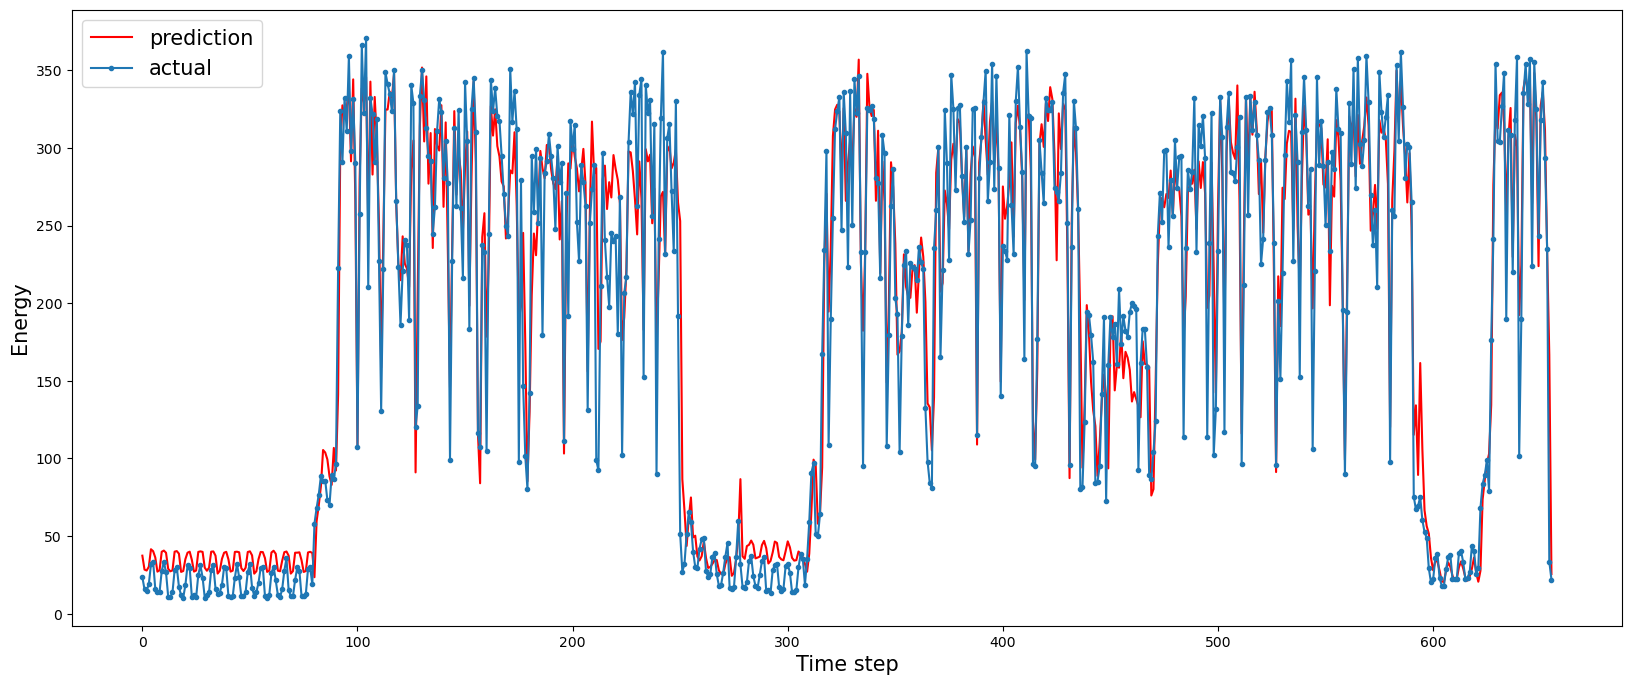

In [55]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

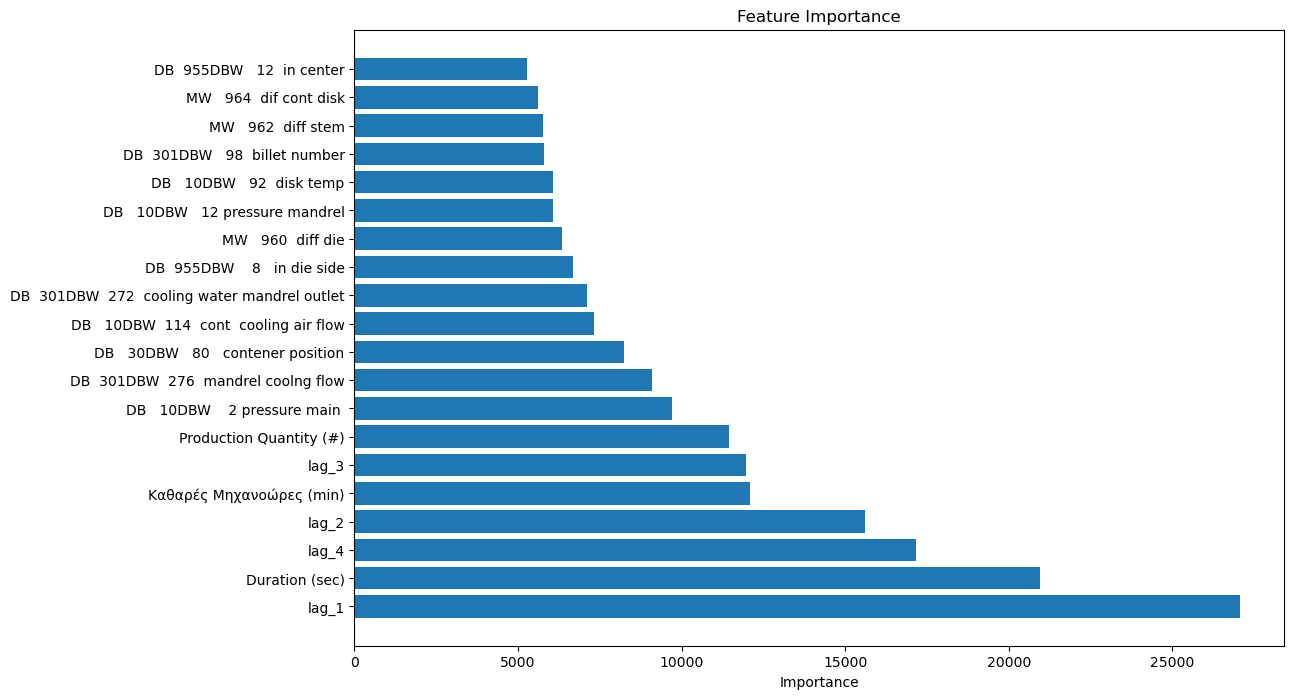

In [62]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
column_names = list(column_names)

importance_df['Feature'] = importance_df['Feature'].replace(
    {f'f{i}': column_names[i] for i in range(len(column_names))}
)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

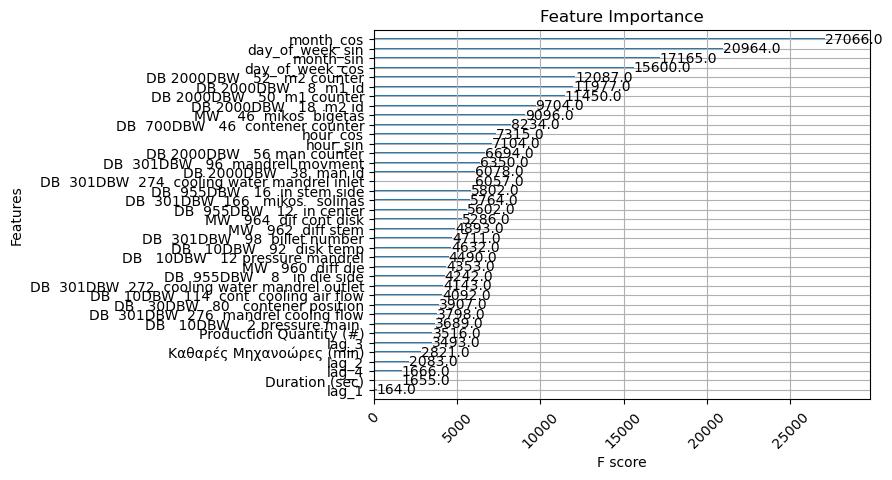

In [9]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.yticks(ticks=np.arange(len(importance_df)), labels=importance_df['Feature'])
plt.show()


In [28]:
temp = importance_df

In [37]:
importance_df['Feature'] = importance_df['Feature'].astype("category")
importance_df.dtypes

Feature       category
Importance     float64
dtype: object

In [57]:
import shap
# model_wrapper = lambda X: model.predict(xgb.DMatrix(X))

explainer = shap.Explainer(model, train_data.get_data().toarray())
shap_values  = explainer.shap_values(test_data.get_data().toarray())

# shap_values = explanation.values
# # make sure the SHAP values add up to marginal predictions
# np.abs(shap_values.sum(axis=1) + explanation.base_values - predictions).max()
# shap.plots.beeswarm(explanation)

 99%|===================| 650/656 [01:03<00:00]        

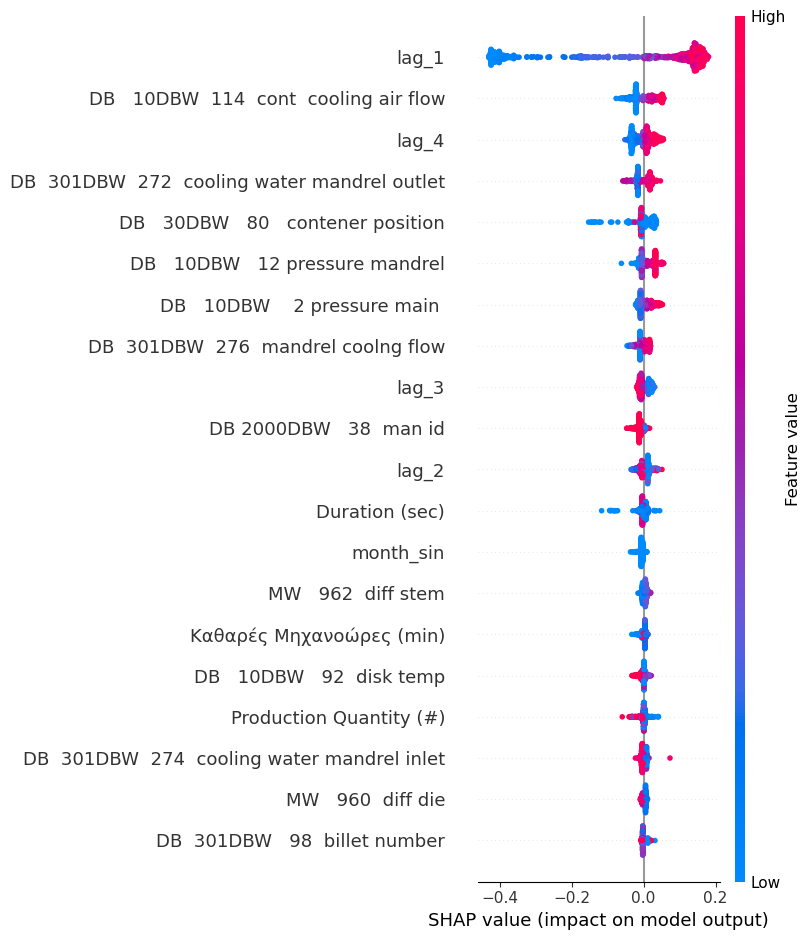

In [58]:
shap.summary_plot(shap_values, test_data.get_data().toarray(), feature_names=list(column_names))
